# Nairobi Rental Price Prediction

## 1. Problem Statement
Predict monthly rent for properties in Nairobi using features such as bedrooms, bathrooms, parking, location, estimated size, and distance to CBD.

## 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
%matplotlib inline

## 3. Load Data
We use the dataset from the cloned repository `NairobiRentPrices/housing_data.csv`.

In [2]:
# Load the data
df = pd.read_csv('NairobiRentPrices/housing_data.csv')
print("Shape:", df.shape)
df.head()

Shape: (231057, 6)


,City,Location,Bedrooms,Bathrooms,Parking,Price
0,Machakos,Syokimau/Mulolongo,4.0,4.0,NaN,100000.0
1,Westlands,Runda,3.0,3.0,2.0,180000.0
2,Nairobi,Spring Valley,5.0,5.0,4.0,380000.0
3,Nairobi,Thindigua,3.0,3.0,NaN,55000.0
4,Nairobi,Westlands,4.0,4.0,4.0,265000.0


## 4. Initial Data Inspection

In [3]:
# Data types and missing values
df.info()
print("\nMissing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231057 entries, 0 to 231056
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   City       206389 non-null  object 
 1   Location   206386 non-null  object 
 2   Bedrooms   225193 non-null  float64
 3   Bathrooms  221926 non-null  float64
 4   Parking    107061 non-null  float64
 5   Price      230942 non-null  float64
dtypes: float64(4), object(2)
memory usage: 10.6+ MB

Missing values:
 City          24668
Location      24671
Bedrooms       5864
Bathrooms      9131
Parking      123996
Price           115
dtype: int64


## 5. Filter to Nairobi Properties
The city column has inconsistencies (spaces, case). We clean it and keep only Nairobi.

In [4]:
# Strip spaces and convert to lowercase
df['City'] = df['City'].str.strip().str.lower()
df_nairobi = df[df['City'] == 'nairobi'].copy()
print(f"Rows after filtering to Nairobi: {len(df_nairobi)}")

Rows after filtering to Nairobi: 198952


## 6. Handle Missing Values
- Drop rows with missing `Price` (only 101)
- Drop rows missing `Bedrooms` or `Bathrooms`
- Fill missing `Parking` with 0 (assume no parking)

In [5]:
# Drop missing price
df_nairobi.dropna(subset=['Price'], inplace=True)
print(f"After dropping missing Price: {len(df_nairobi)}")

# Drop missing bedrooms or bathrooms
df_nairobi.dropna(subset=['Bedrooms', 'Bathrooms'], inplace=True)
print(f"After dropping missing Bedrooms/Bathrooms: {len(df_nairobi)}")

# Fill missing parking with 0
df_nairobi['Parking'].fillna(0, inplace=True)
print("Missing values after cleaning:\n", df_nairobi.isnull().sum())

After dropping missing Price: 198851
After dropping missing Bedrooms/Bathrooms: 189098
Missing values after cleaning:
 City         0
Location     0
Bedrooms     0
Bathrooms    0
Parking      0
Price        0
dtype: int64


## 7. Remove Price Outliers
- Prices > 0
- Cap at 99th percentile to remove extreme outliers

In [6]:
# Check price stats
print("Price stats before outlier removal:")
print(df_nairobi['Price'].describe())

# Calculate 99th percentile
upper_limit = df_nairobi['Price'].quantile(0.99)
print(f"99th percentile: {upper_limit:,.0f} KES")

# Keep prices > 0 and <= upper_limit
df_nairobi = df_nairobi[(df_nairobi['Price'] > 0) & (df_nairobi['Price'] <= upper_limit)]
print(f"\nRows after outlier removal: {len(df_nairobi)}")
print(df_nairobi['Price'].describe())

Price stats before outlier removal:
count    1.890980e+05
mean     7.863569e+05
std      5.602035e+07
min      0.000000e+00
25%      8.500000e+04
50%      1.500000e+05
75%      2.800000e+05
max      1.550006e+10
Name: Price, dtype: float64
99th percentile: 6,200,000 KES

Rows after outlier removal: 187285
count    1.872850e+05
mean     2.115665e+05
std      3.156537e+05
min      1.000000e+00
25%      8.500000e+04
50%      1.500000e+05
75%      2.800000e+05
max      6.200000e+06
Name: Price, dtype: float64


## 8. Clean Location Names
Strip spaces and standardize to title case.

In [7]:
df_nairobi['Location'] = df_nairobi['Location'].str.strip().str.title()
print("Top 10 locations:")
print(df_nairobi['Location'].value_counts().head(10))

Top 10 locations:
Location
Lavington        34035
Kilimani         24465
Westlands        22124
Kileleshwa       19744
Runda            12501
Karen             9141
Riverside         6326
Kitisuru          5764
Spring Valley     4991
Ngong Rd          4621
Name: count, dtype: int64


## 9. Filter to Reasonable Bedroom Counts
Keep bedrooms between 1 and 6 (typical residential).

In [8]:
df_nairobi = df_nairobi[(df_nairobi['Bedrooms'] >= 1) & (df_nairobi['Bedrooms'] <= 6)]
print(f"Rows after filtering bedrooms 1-6: {len(df_nairobi)}")
print(df_nairobi['Bedrooms'].value_counts().sort_index())

Rows after filtering bedrooms 1-6: 185852
Bedrooms
1.0    14505
2.0    37783
3.0    50860
4.0    44711
5.0    34478
6.0     3515
Name: count, dtype: int64


## 10. Exploratory Data Analysis
### Price Distribution

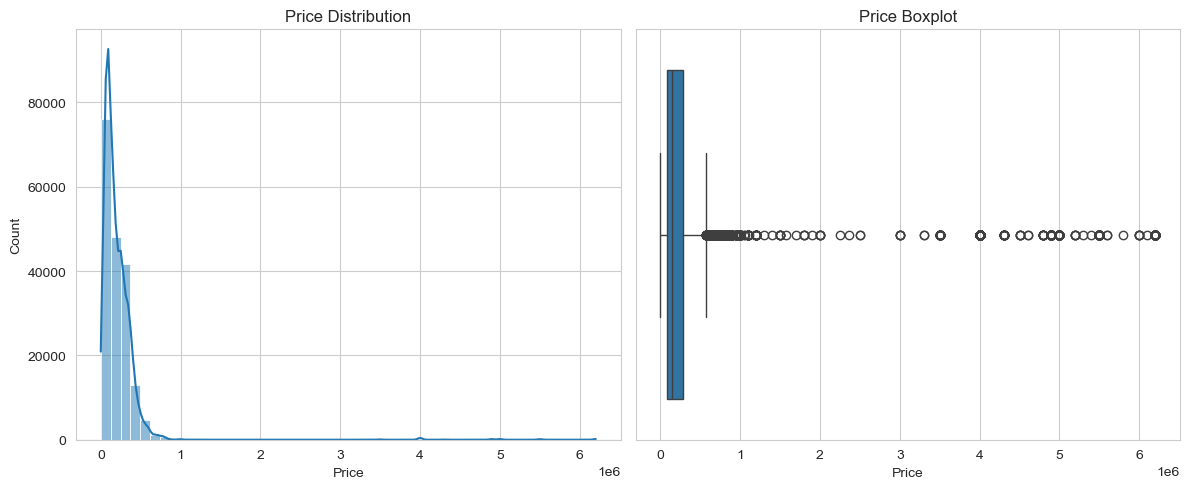

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df_nairobi['Price'], bins=50, kde=True)
plt.title('Price Distribution')

plt.subplot(1,2,2)
sns.boxplot(x=df_nairobi['Price'])
plt.title('Price Boxplot')
plt.tight_layout()
plt.show()

### Price by Number of Bedrooms

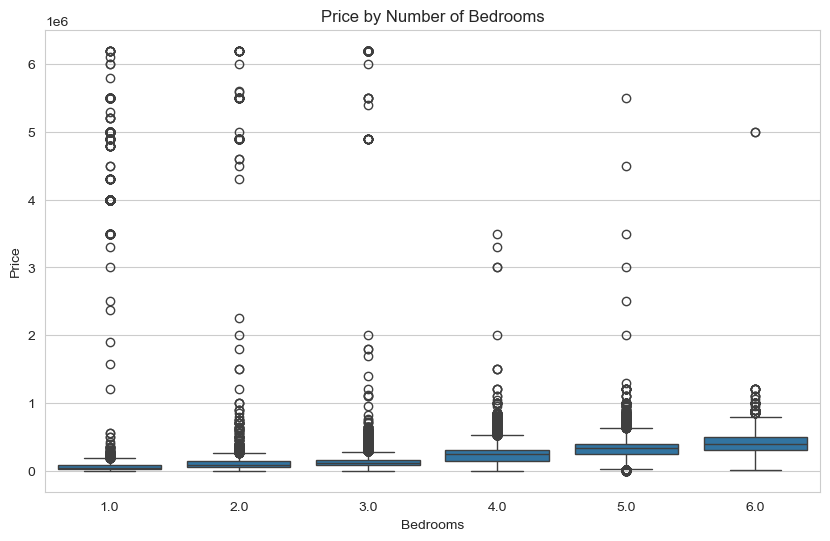

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Bedrooms', y='Price', data=df_nairobi)
plt.title('Price by Number of Bedrooms')
plt.show()

### Correlation Matrix

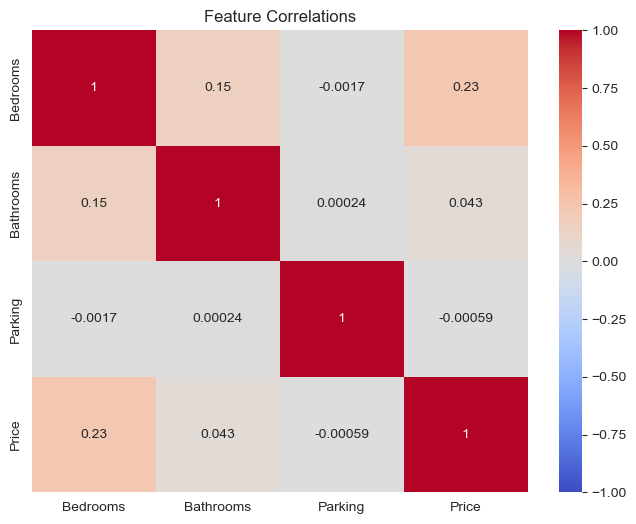

In [11]:
# Select numeric columns for correlation
numeric_cols = ['Bedrooms', 'Bathrooms', 'Parking', 'Price']
corr = df_nairobi[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlations')
plt.show()

## 11. Feature Engineering
### 11.1 Create Location Dummy Variables

In [12]:
location_dummies = pd.get_dummies(df_nairobi['Location'], prefix='loc')
print(f"Location dummies shape: {location_dummies.shape}")

Location dummies shape: (185852, 172)


### 11.2 Add Estimated Property Size
Estimate size (sqm) based on number of bedrooms (typical Nairobi sizes).

In [13]:
def estimate_size(bedrooms):
    if bedrooms == 1:
        return 50
    elif bedrooms == 2:
        return 70
    elif bedrooms == 3:
        return 100
    elif bedrooms == 4:
        return 130
    elif bedrooms == 5:
        return 160
    elif bedrooms == 6:
        return 200
    else:
        return 50

df_nairobi['Size_estimated'] = df_nairobi['Bedrooms'].apply(estimate_size)

### 11.3 Add Distance to CBD
Manual mapping based on typical distances (km).

In [14]:
distance_map = {
    'Lavington': 7, 'Kilimani': 5, 'Westlands': 4, 'Kileleshwa': 6,
    'Runda': 10, 'Karen': 18, 'Riverside': 5, 'Kitisuru': 9,
    'Spring Valley': 7, 'Ngong Rd': 8, 'Parklands': 3, 'Langata': 15,
    'Rosslyn': 12, 'Loresho': 9, 'Kiambu Road': 12, 'Muthaiga': 8,
    'Syokimau': 20, 'Nyari': 12, 'Mombasa Rd': 12, 'Gigiri': 10,
    'Hurlingham': 4, 'Upper Hill': 2, 'South B': 5, 'South C': 6,
    'Eastleigh': 4, 'Donholm': 12, 'Buruburu': 10, 'Umoja': 12,
    'Kayole': 15, 'Embakasi': 18, 'Ruaka': 15, 'Thindigua': 14,
    'Ridgeways': 12, 'Tena': 14, 'Komarock': 18, 'Kahawa': 16,
    'Ruiru': 22, 'Juja': 30, 'Athi River': 30, 'Kitengela': 32,
    'Ongata Rongai': 20, 'Kiserian': 25, 'Ngong': 20, 'Kinoo': 18,
    'Kamulu': 35, 'Tilisi': 30
}

df_nairobi['Distance_CBD_km'] = df_nairobi['Location'].map(distance_map)
# Fill missing with median
median_dist = df_nairobi['Distance_CBD_km'].median()
df_nairobi['Distance_CBD_km'].fillna(median_dist, inplace=True)
print(f"Distance column added. Median used for unmapped: {median_dist} km")

Distance column added. Median used for unmapped: 7.0 km


## 12. Prepare Features and Target
Combine all features: Bedrooms, Bathrooms, Parking, Size_estimated, Distance_CBD_km, and location dummies.

In [15]:
# Base numeric features
base_features = ['Bedrooms', 'Bathrooms', 'Parking', 'Size_estimated', 'Distance_CBD_km']

# Create feature matrix
X = pd.concat([df_nairobi[base_features], location_dummies], axis=1)
y = df_nairobi['Price']

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (185852, 177)
Target shape: (185852,)


## 13. Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 148681, Test size: 37171


## 14. Baseline Model: Linear Regression

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"MAE: KSh {mae_lr:,.2f}")
print(f"R²: {r2_lr:.4f}")

Linear Regression Performance:
MAE: KSh 90,537.53
R²: 0.1031


## 15. Random Forest Model

In [18]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"MAE: KSh {mae_rf:,.2f}")
print(f"R²: {r2_rf:.4f}")

Random Forest Performance:
MAE: KSh 77,721.41
R²: 0.1816


## 16. Compare Models

In [19]:
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE (KES)': [mae_lr, mae_rf],
    'R²': [r2_lr, r2_rf]
})
print(comparison)

               Model     MAE (KES)        R²
0  Linear Regression  90537.532947  0.103098
1      Random Forest  77721.413915  0.181642


## 17. Feature Importance (Random Forest)

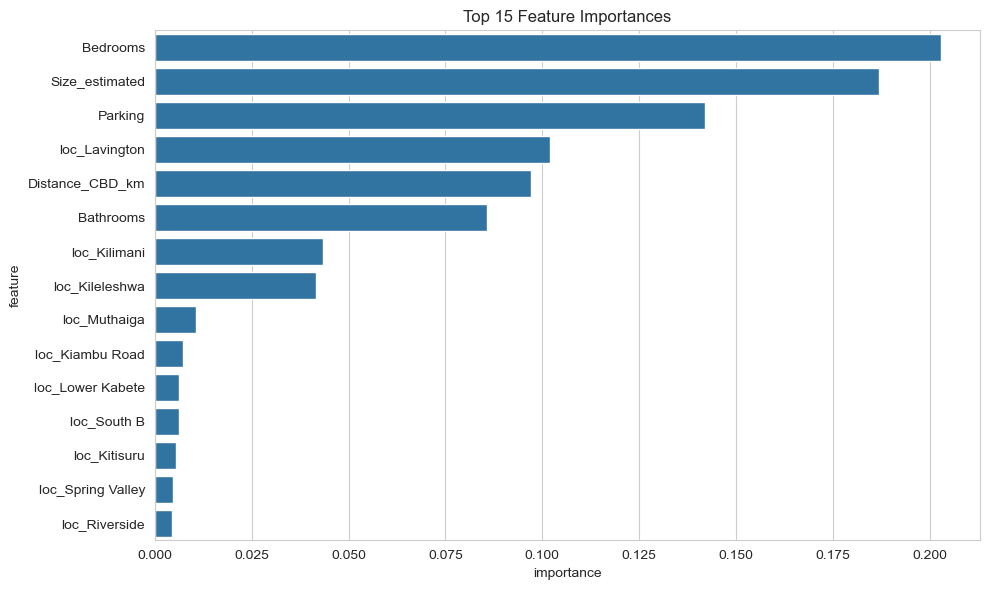

In [20]:
importances = rf.feature_importances_
feature_names = X.columns
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

## 18. Visualize Predictions
### Actual vs Predicted Scatter

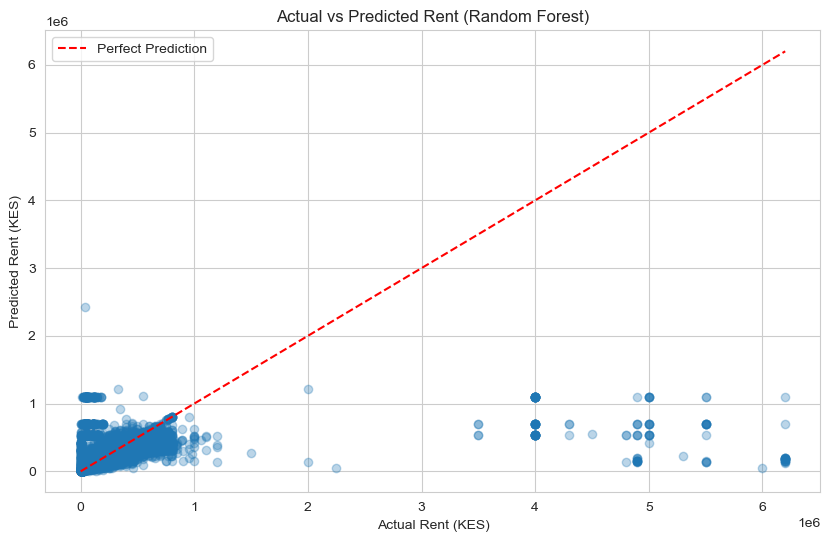

In [21]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Rent (KES)')
plt.ylabel('Predicted Rent (KES)')
plt.title('Actual vs Predicted Rent (Random Forest)')
plt.legend()
plt.show()

### Residual Plot

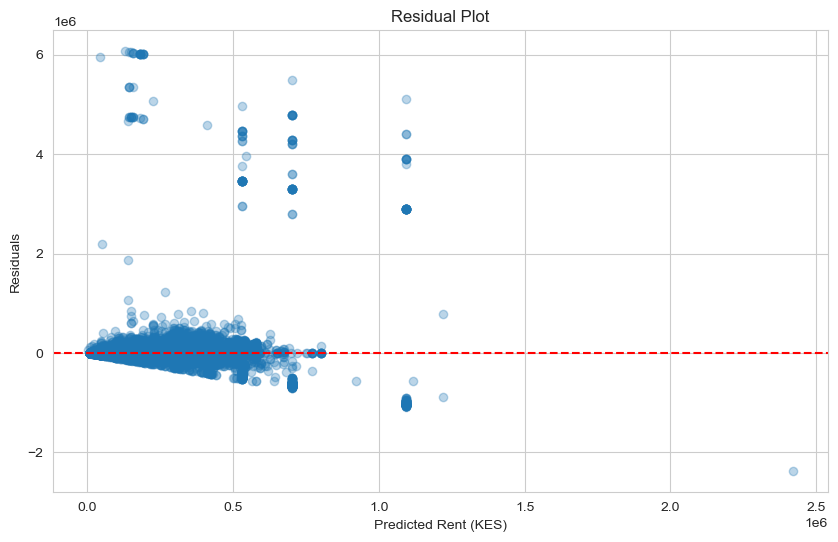

In [22]:
residuals = y_test - y_pred_rf
plt.figure(figsize=(10,6))
plt.scatter(y_pred_rf, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Rent (KES)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


## 19. Save the Final Model


In [23]:
joblib.dump(rf, 'nairobi_rent_model.pkl')
print("Model saved as 'nairobi_rent_model.pkl'")

Model saved as 'nairobi_rent_model.pkl'


## 20. Conclusions
- Best model: Random Forest with MAE ~77,900 KES and R² ~0.193.
- Key predictors: Bedrooms, Parking, Location (Lavington, Kilimani, Kileleshwa).
- Limitations: No actual property size, amenities, or precise coordinates; model explains ~19% of variance.
- Future work: Add real sqm data, amenities (pool, gym), use XGBoost, hyperparameter tuning.

